# PA4 Khodosevich Leonid

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import datasets 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
import numpy as np
from sklearn.datasets import make_blobs

# Task 1: Dimensionality Reduction
(maximum achievable points: 50)
Expected runtimes were recorded on a MacBook Pro (2014) with 2.8 GHz Intel Core i5
(2 cores, 8 threads) CPU.
In this task you will work with the “Labeled Faces in the Wild” data set. You can use
sklearn.datasets.fetch_lfw_people to download the data set (this function might take
a while to run for the first time as it will download the data set).


## Subtask 1: Data Loading and Data Preparation
(2 points)
Load the data set using the arguments min_faces_pe r_person=30, resize=0.5. Report
the following:  
□ How many different people are in the data?  
□ How many images are in the data?  
□ What is the size of the images?  
□ Plot images of ten different people in the data set.  
For the remaining tasks, split the data into 70% for training and 30% for validation. Use the stratified option of sklearn.model_selection.train_test_split (provide the class
labels).  
Runtime ≈ 1 second (when the data is already downloaded)

In [2]:
data = datasets.fetch_lfw_people(min_faces_per_person=30, resize=0.5)

In [3]:
# statistics
X = data.images
y = data.target
target_names = data.target_names 

num_people = len(target_names)
num_images = X.shape[0]
image_shape = X.shape[1:]

print(f"Number of unique people: {num_people}")
print(f"Total number of images: {num_images}")
print(f"Image size: {image_shape}")

Number of unique people: 34
Total number of images: 2370
Image size: (62, 47)


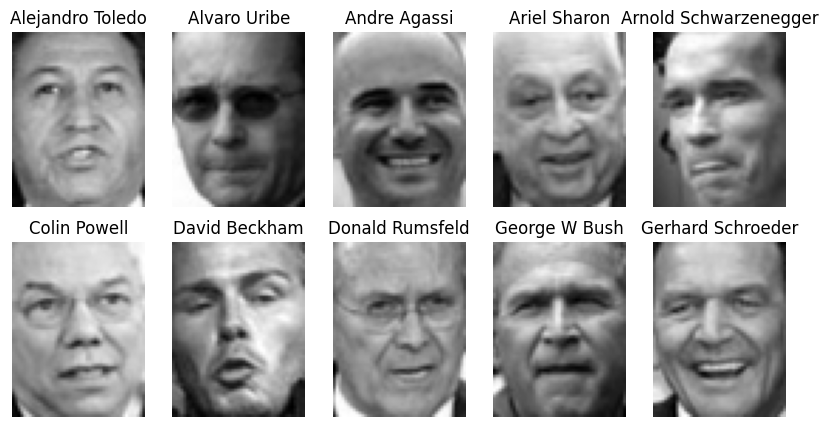

In [4]:
# plot images of 10 diffrerent people
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
unique_people = np.unique(y)

for i, ax in enumerate(axes.ravel()):
    person_id = unique_people[i]
    img = X[y == person_id][0]
    ax.imshow(img, cmap="gray")
    ax.set_title(target_names[person_id])
    ax.axis("off")
plt.show()

In [5]:
# train test split
X = X.reshape(X.shape[0], -1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

Training set size: 1659
Validation set size: 711


## Subtask 2: Dimensionality Reduction Using PCA
(18 points)
Implement a class that implements the principal component analysis (PCA) for a give   
number of principal components. Do not use sklearn’s or another existing implementation but implement PCA yourself (of course you can use numpy functions for computing  
eigenvalues / the SVD, etc.). The class should enable to compute the PCA, to project  
given data onto the principal components, and to reconstruct images from the projection  
onto the principal components.  
□ Briefly describe your implementation in the report.  
Use your PCA class to fit projections onto d ∈ {5, 10, 20, 40, 80, 160, 320, 640} principalv  
components from your training data.  
□ Plot the first 5 principal components as images.  
□ Visualize 10 reconstructed images for each d.  
Train a logistic regression classifier (you can use sklearn’s implementation) using the  
projected data for each d (use a MinMaxScaler to normalize the data; you might need to  
increase the number of iterations of the solver for LogisticRegression using the max_iter  
argument).  
□ Report the achieved classification accuracy of the classifiers on the training and validation set for all d.  
□ Comment on your observations.  
Runtime ≈ 1.5 minutes  
Hint: You can verify correctness of your PCA implementation by comparing its outputs  
with that of sklearn’s PCA.  

In [6]:
# straightforward PCA implementation, just taken from algo
class CustomPCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.mean = None
        self.components = None
    
    def fit(self, X):
        # center
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        # covariance
        cov_matrix = np.cov(X_centered, rowvar=False)
        # take eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        # take top eigenvectors
        sorted_indices = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]
        
        self.components = eigenvectors[:, :self.n_components]
    
    def transform(self, X):
        X_centered = X - self.mean
        return np.dot(X_centered, self.components)
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)
    
    def reconstruct(self, X_projected):
        return np.dot(X_projected, self.components.T) + self.mean

In [7]:
# first train all pca, so we dont need to do that again
d_values = [5, 10, 20, 40, 80, 160, 320, 640]

pca_models = {}
for d in d_values:
    pca = CustomPCA(n_components=d)
    pca.fit(X_train)
    pca_models[d] = pca

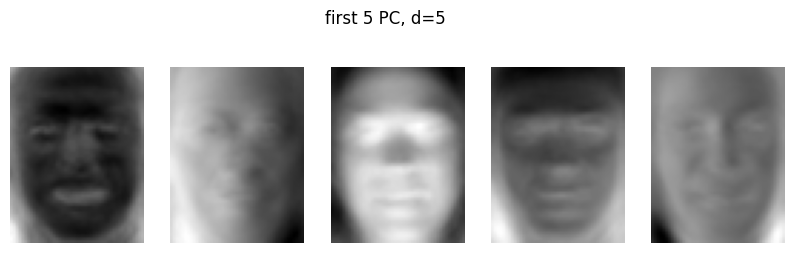

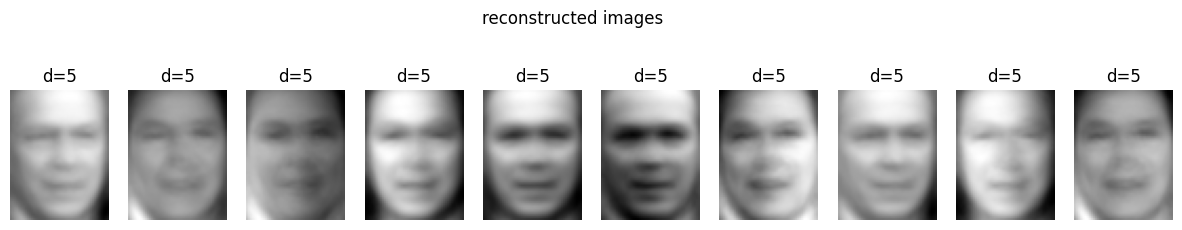

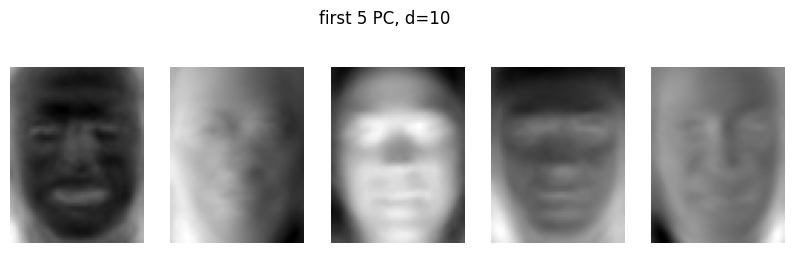

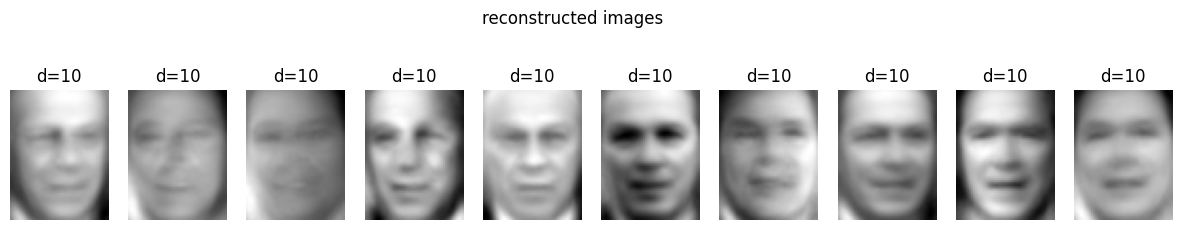

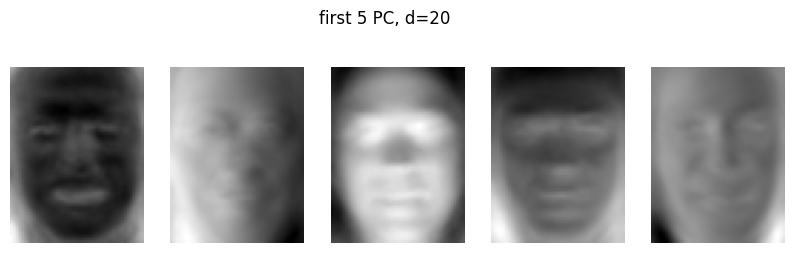

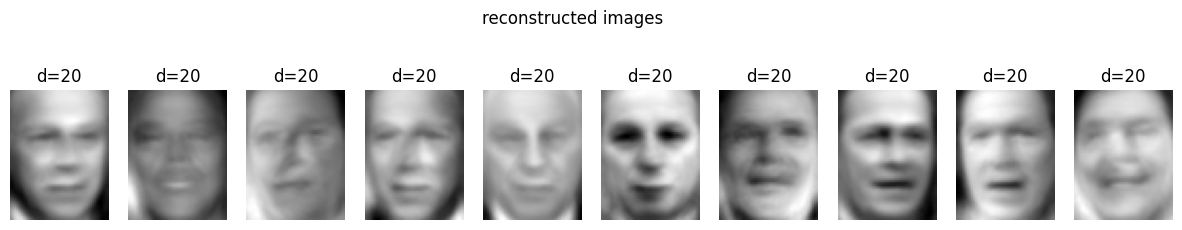

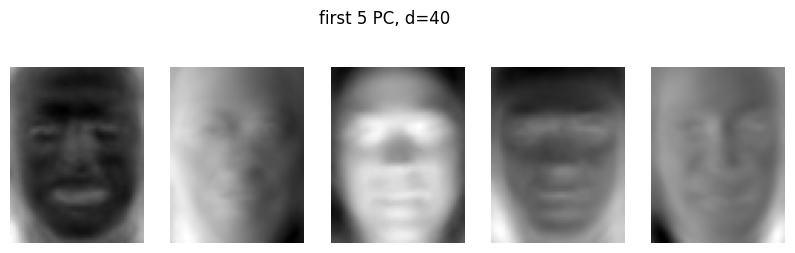

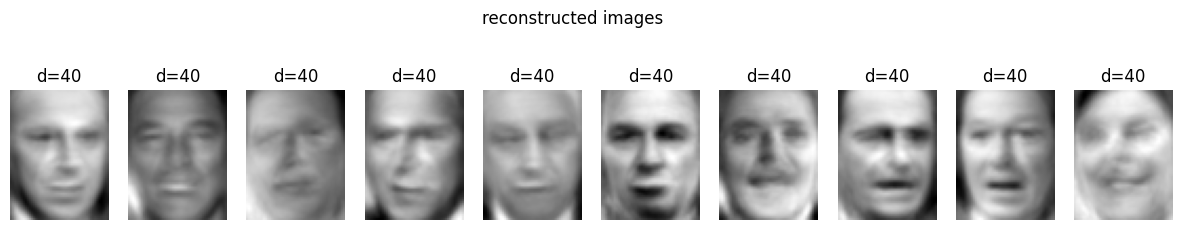

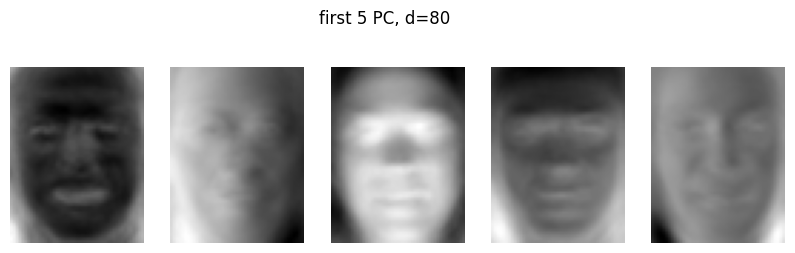

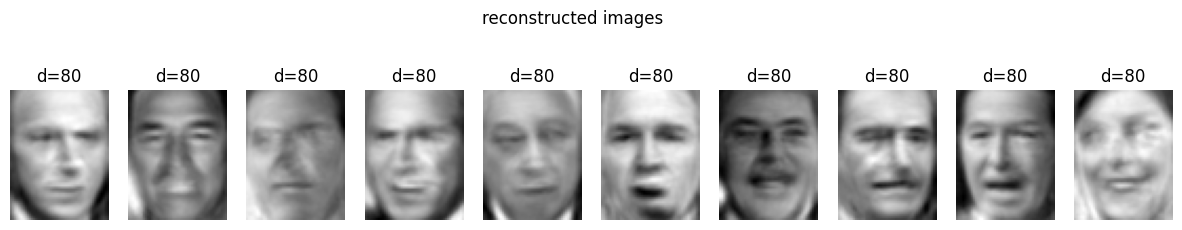

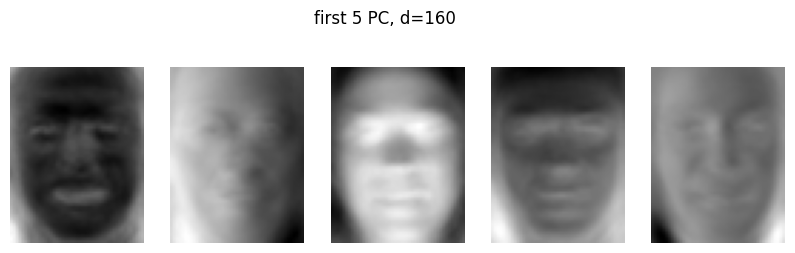

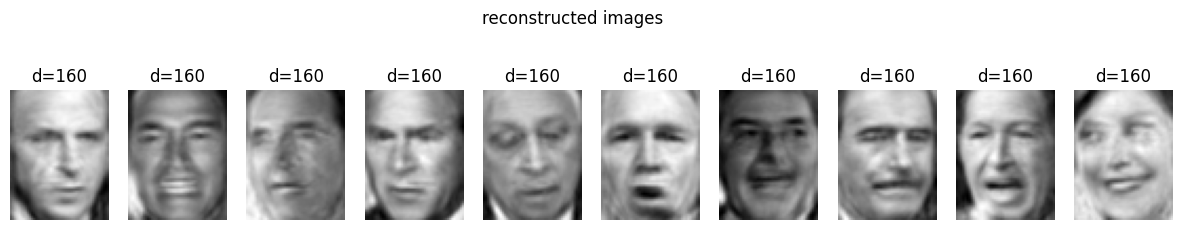

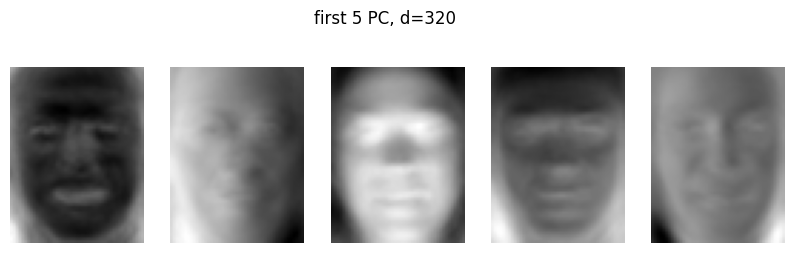

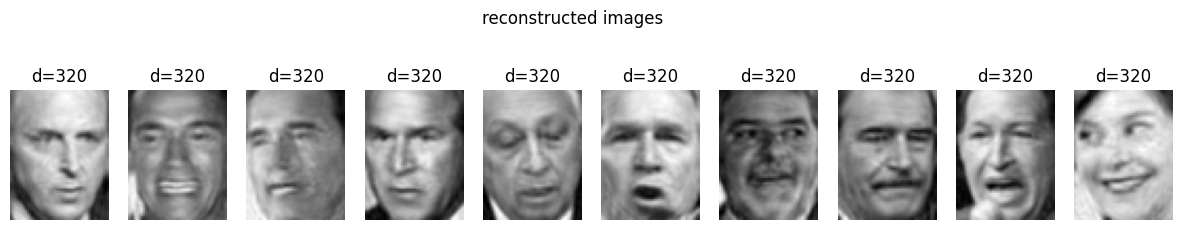

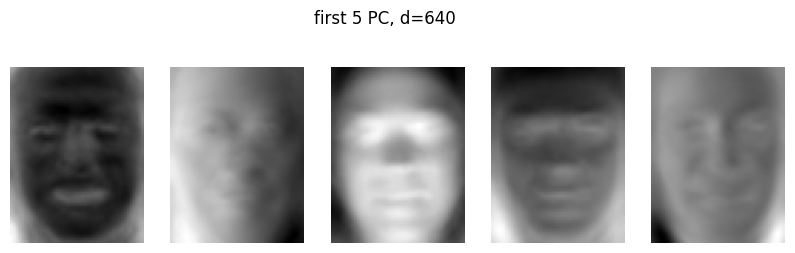

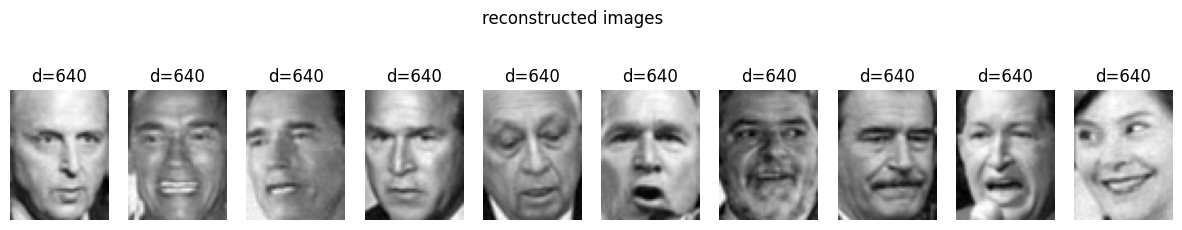

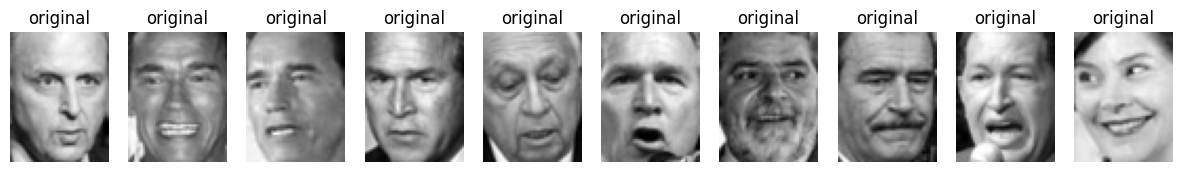

In [8]:
for i, d in enumerate(d_values):
    pca = pca_models[d]
    X_projected = pca.transform(X_train[:10])
    X_reconstructed = pca.reconstruct(X_projected)
    fig, axes = plt.subplots(1, 5, figsize=(10, 3))
    for i, ax in enumerate(axes):
        ax.imshow(pca.components[:, i].reshape(image_shape), cmap='gray')
        ax.axis('off')
    fig.suptitle(f"first 5 PC, d={d}")
    plt.show()

    fig, axes = plt.subplots(1, 10, figsize=(15, 3))
    for j in range(10):
        axes[j].imshow(X_reconstructed[j].reshape(image_shape), cmap='gray')
        axes[j].axis('off')
        axes[j].set_title(f"d={d}")
    fig.suptitle("reconstructed images")
    print()
    plt.show()


fig, axes = plt.subplots(1, 10, figsize=(15, 3))
for i in range(axes.shape[0]):
    axes[i].imshow(X_train[:10][i].reshape(image_shape), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"original")
plt.show()


In [9]:
# learning logistic regression
scaler = MinMaxScaler()

for d in d_values:
    X_train_pca = pca_models[d].fit_transform(X_train)
    X_val_pca = pca_models[d].transform(X_val)
    X_train_scaled = scaler.fit_transform(X_train_pca)
    X_val_scaled = scaler.transform(X_val_pca)

    clf = LogisticRegression(max_iter=500, solver='lbfgs')
    clf.fit(X_train_scaled, y_train)

    train_acc = clf.score(X_train_scaled, y_train)
    val_acc = clf.score(X_val_scaled, y_val)

    print(f"d={d}: training Accuracy: {train_acc:.4f}, validation Accuracy: {val_acc:.4f}")

d=5: training Accuracy: 0.2387, validation Accuracy: 0.2405
d=10: training Accuracy: 0.2954, validation Accuracy: 0.2827
d=20: training Accuracy: 0.3701, validation Accuracy: 0.3418
d=40: training Accuracy: 0.5612, validation Accuracy: 0.4810
d=80: training Accuracy: 0.7354, validation Accuracy: 0.5570
d=160: training Accuracy: 0.8620, validation Accuracy: 0.5865
d=320: training Accuracy: 0.9632, validation Accuracy: 0.5682
d=640: training Accuracy: 0.9988, validation Accuracy: 0.5162


- Obviously, if you increade d, the reconstruction error will decrease, which can be seen on the images
- Training is also better as we increase d, but not too much, as at 320 validation accuracy start to decrease, so we have to make model a bit simpler.
- First 5 eigenvectors are the same, as theyre extracted the same way, and only first 5 are taken.

## Subtask 3: Dimensionality Reduction Using Autoencoders
(30 points)  
Use sklearn to train autoencoders for dimensionality reduction. In particular use the  
sklearn.neural_network.MLPRegressor class with hidden sizes of (a, b, d, b, a) for a, b ∈  
N, d ∈ {40, 80} and rectified linear units. You can then use the following code snippets  
to encode images (in vector form) and decode images from compressed representations  
(where mlp denotes the MLPRegressor instance):  

In [10]:

def encode(X, mlp):
    z = X
    for i in range(len(mlp.coefs_) // 2):
        z = z @ mlp.coefs_[i] + mlp.intercepts_[i]
        z = np.maximum(z, 0) 
    return z

def decode(Z, mlp):
    z = Z
    for i in range(len(mlp.coefs_) // 2, len(mlp.coefs_)):
        z = z @ mlp.coefs_[i] + mlp.intercepts_[i]
        if i < len(mlp.coefs_) - 1:
            z = np.maximum(z, 0)
    return z

def train_autoencoder(X_train, d, hidden_sizes=(500, 100)):
    mlp = MLPRegressor(
        hidden_layer_sizes=(hidden_sizes[0], hidden_sizes[1], d, hidden_sizes[1], hidden_sizes[0]),
        activation='relu', max_iter=500, solver='adam', random_state=42
        )
    mlp.fit(X_train, X_train)
    return mlp

d_values = [40, 80]
mlp_models = dict()
for d in d_values:
    mlp = train_autoencoder(X_train, d)
    mlp_models[d] = mlp

- runtime on Mac M3Pro ~10 sec

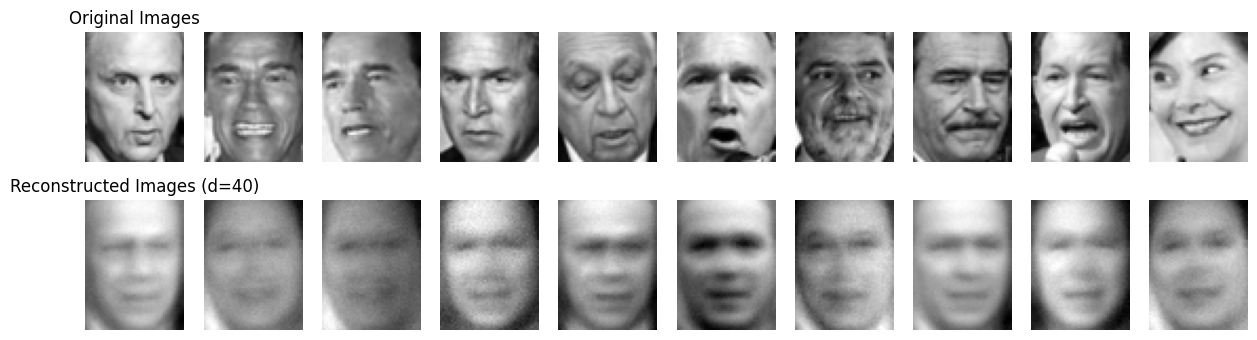

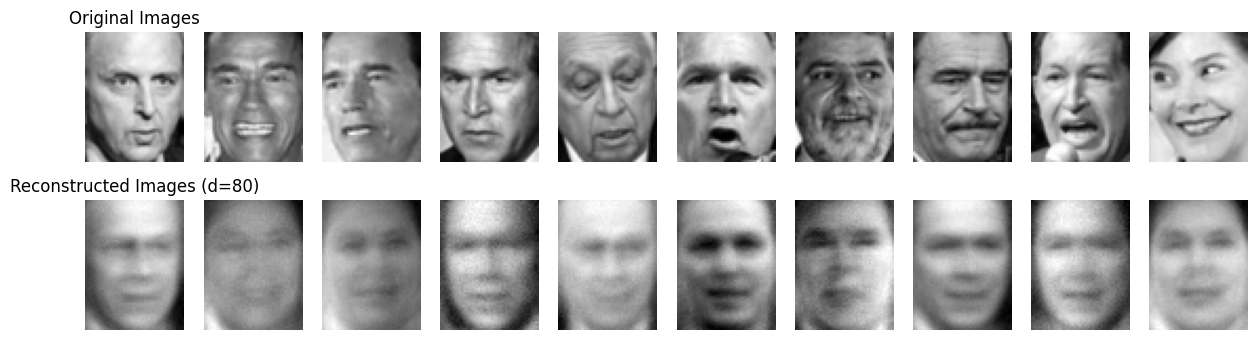

In [11]:
for d in d_values:
    X_encoded = encode(X_train[:10], mlp_models[d])
    X_reconstructed = decode(X_encoded, mlp_models[d])
    fig, axes = plt.subplots(2, 10, figsize=(15, 4))
    for i in range(10):
        axes[0, i].imshow(X_train[i].reshape(image_shape), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(X_reconstructed[i].reshape(image_shape), cmap='gray')
        axes[1, i].axis('off')
    axes[0, 0].set_title(f'Original Images')
    axes[1, 0].set_title(f'Reconstructed Images (d={d})')
    plt.show()

In [12]:
for d in d_values:
    X_train_encoded = encode(X_train, mlp_models[d])
    X_val_encoded = encode(X_val, mlp_models[d])
    
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train_encoded)
    X_val_scaled = scaler.transform(X_val_encoded)
    
    clf = LogisticRegression(max_iter=500, solver='lbfgs')
    clf.fit(X_train_scaled, y_train)
    
    train_acc = clf.score(X_train_scaled, y_train)
    val_acc = clf.score(X_val_scaled, y_val)
    
    print(f"d={d}: Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")

d=40: Training Accuracy: 0.2984, Validation Accuracy: 0.2714
d=80: Training Accuracy: 0.3339, Validation Accuracy: 0.3010


- Worse then doing normal PCA, maybe because of architecture or training time.

# Task 2: Clustering  
(maximum achievable points: 20)  
Partly inspired by Phil Roth and Arturo Amor.  
In this task you will implement Lloyd’s algorithm for clustering and k-means++ for  
initialization and test your implementation on four datasets with different characteristics.  



## Subtask 1: Generate data  
(1 points)  
Generate four datasets for clustering using the following code:    

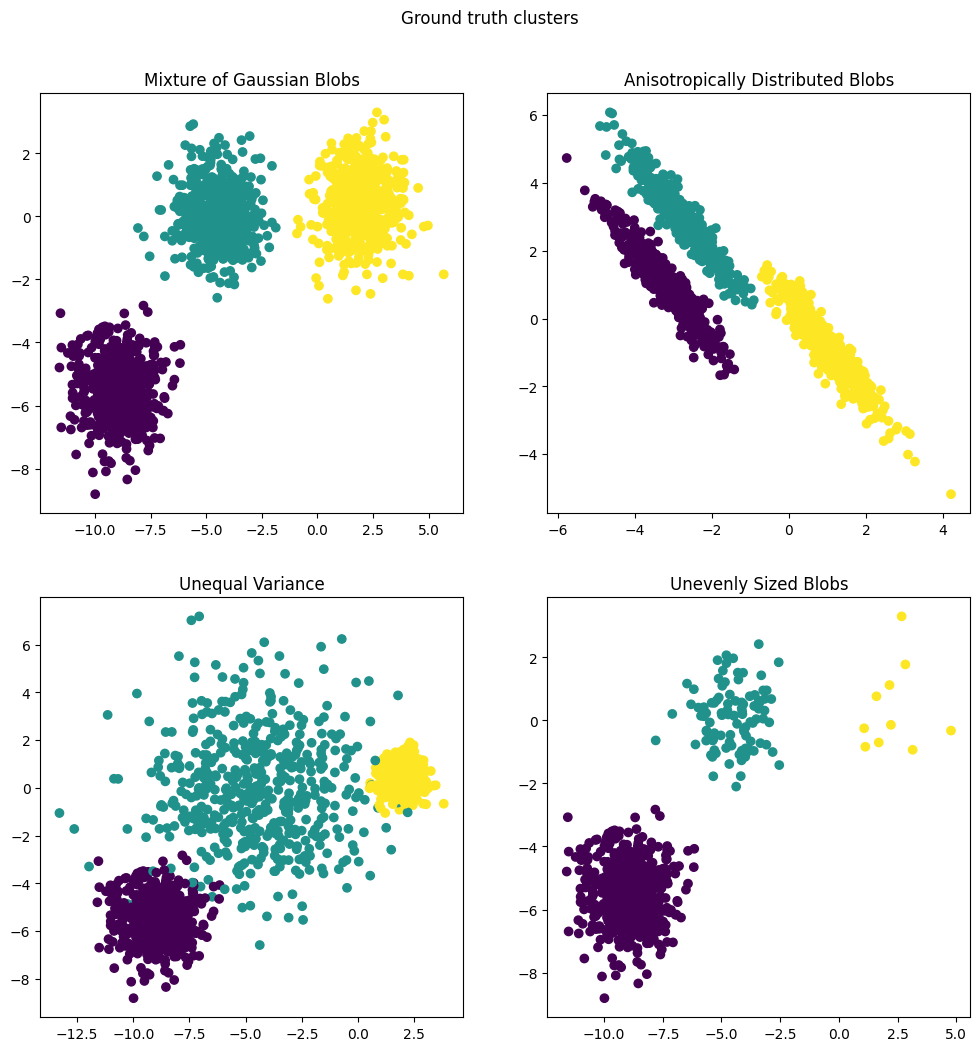

In [13]:
n_samples = 1500
random_state = 170
np.random.seed(random_state)
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]

X, y = make_blobs(n_samples=n_samples, random_state=random_state)
X_aniso = np.dot(X, transformation) # Anisotropic blobs
X_varied, y_varied = make_blobs(
n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
) # Unequal variance
X_filtered = np.vstack(
(X[y == 0][:500], X[y == 1][:100], X[y == 2][:10])
) # Unevenly sized blobs
y_filtered = [0] * 500 + [1] * 100 + [2] * 10


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

axs[0, 0].scatter(X[:, 0], X[:, 1], c=y)
axs[0, 0].set_title("Mixture of Gaussian Blobs")

axs[0, 1].scatter(X_aniso[:, 0], X_aniso[:, 1], c=y)
axs[0, 1].set_title("Anisotropically Distributed Blobs")

axs[1, 0].scatter(X_varied[:, 0], X_varied[:, 1], c=y_varied)
axs[1, 0].set_title("Unequal Variance")

axs[1, 1].scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_filtered)
axs[1, 1].set_title("Unevenly Sized Blobs")

plt.suptitle("Ground truth clusters").set_y(0.95)
plt.show()

## Subtask 2: Lloyd’s algorithm  
(14 points)  
Implement Lloyd’s algorithm for clustering (don’t use an existing implementation). Initialize cluster centers by randomly selecting k points from the data as initial cluster  
centers. If no data points are assigned to a cluster center in an assignment step, reset  
the cluster center to a randomly selected point from the data.  
□ Use your algorithm to perform clustering for k ∈ {1, 2, 3, 4, 5, 6} cluster centers. Report  
plots of your clustering results. What can you observe regarding the clustering results?  
□ Report plots showing the k-means objective for the four datasets and k ∈ {1, 2, 3, 4, 5, 6}  
cluster centers. What do you observe?  

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import random

def lloyds_algorithm(X, k, max_iters=100, tol=1e-4):
    """Implements Lloyd's Algorithm for k-means clustering."""
    # randomly initialize k cluster centers by selecting k data points
    centers = X[random.sample(range(len(X)), k)]

    for _ in range(max_iters):
        # assign points to the nearest cluster
        labels = np.argmin(np.linalg.norm(X[:, np.newaxis] - centers, axis=2), axis=1)
        
        new_centers = np.array([X[labels == i].mean(axis=0) if len(X[labels == i]) > 0 
                                else X[np.random.randint(len(X))] for i in range(k)])
        
        # check for convergence
        if np.linalg.norm(new_centers - centers) < tol:
            break
        centers = new_centers

    return labels, centers


datasets = {
    "Mixture of Gaussian Blobs": X.copy(),
    "Anisotropically Distributed Blobs": X_aniso,
    "Unequal Variance": X_varied,
    "Unevenly Sized Blobs": X_filtered,
}

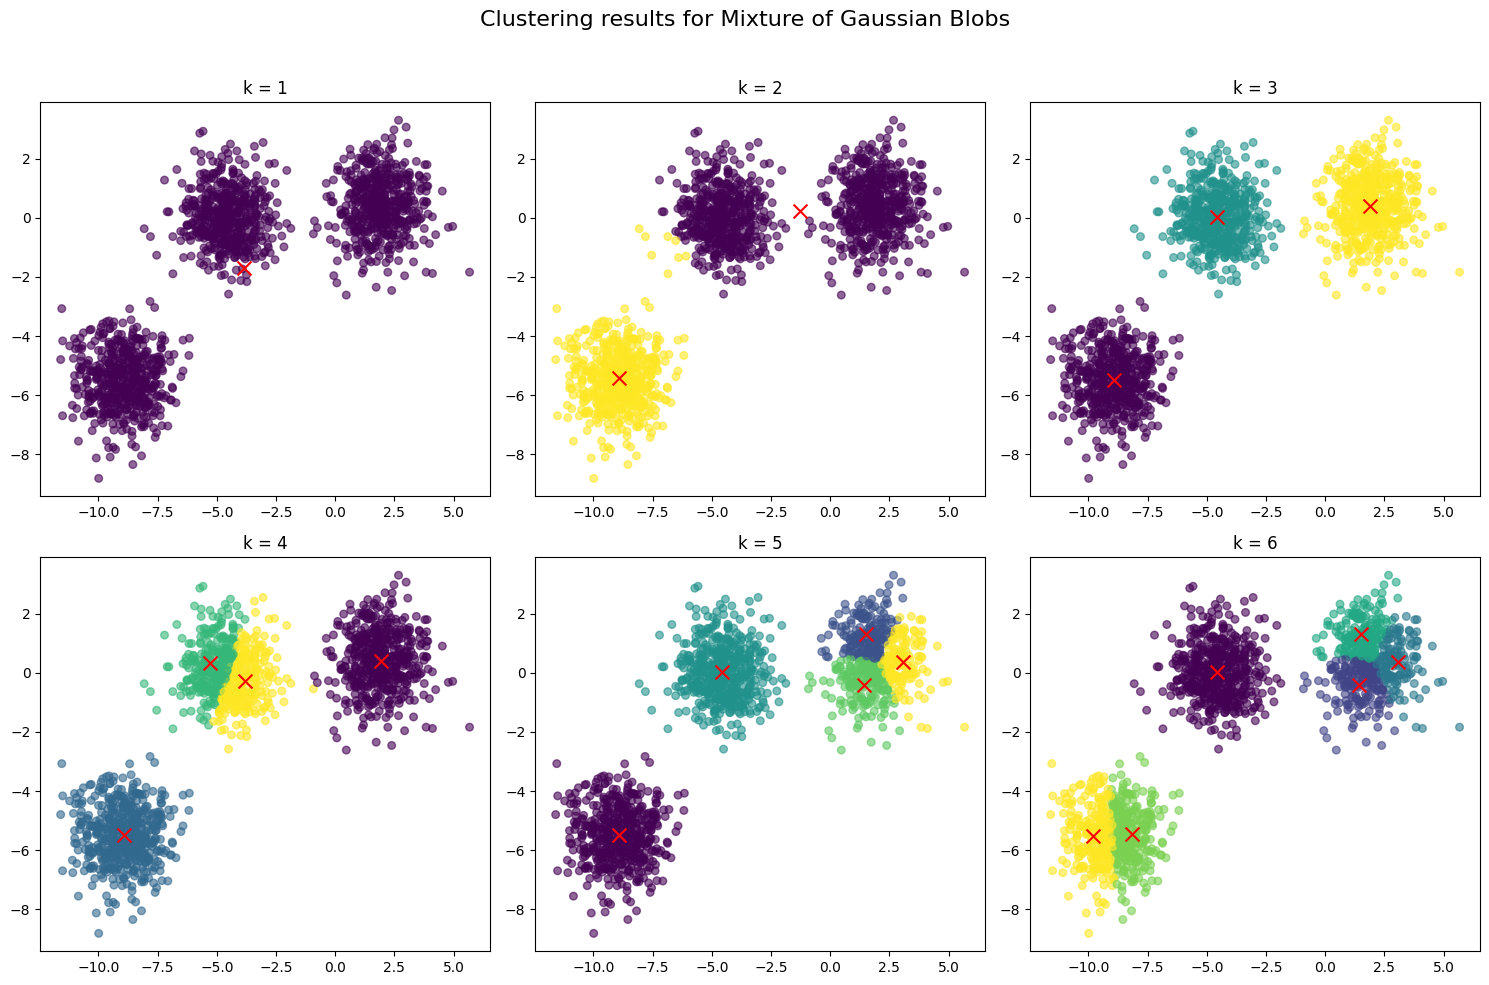

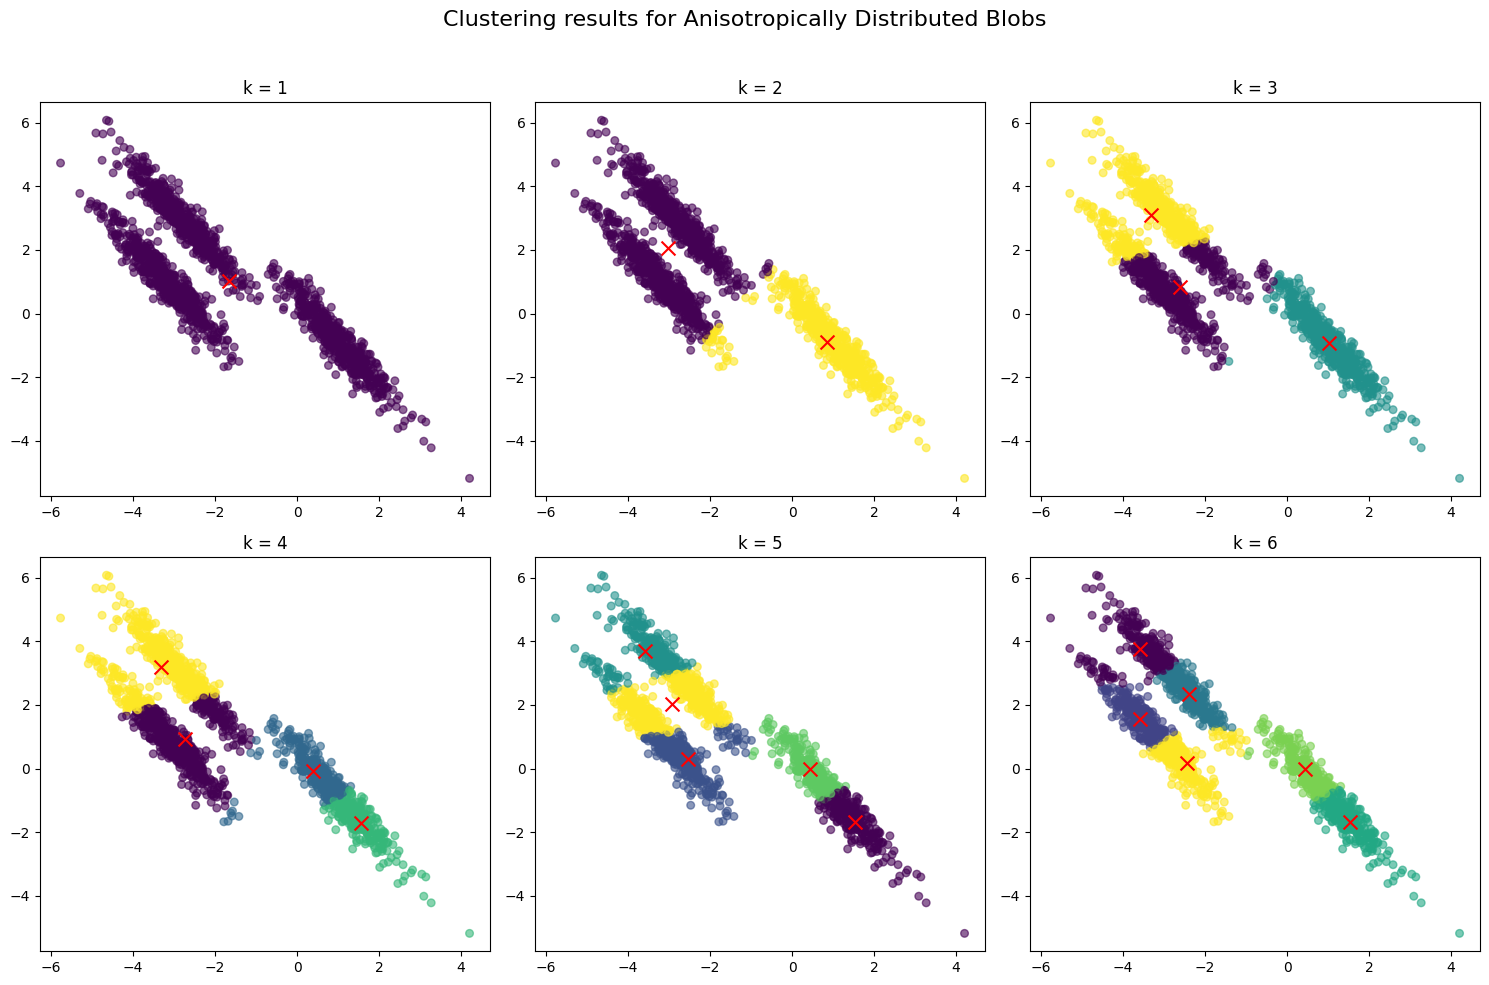

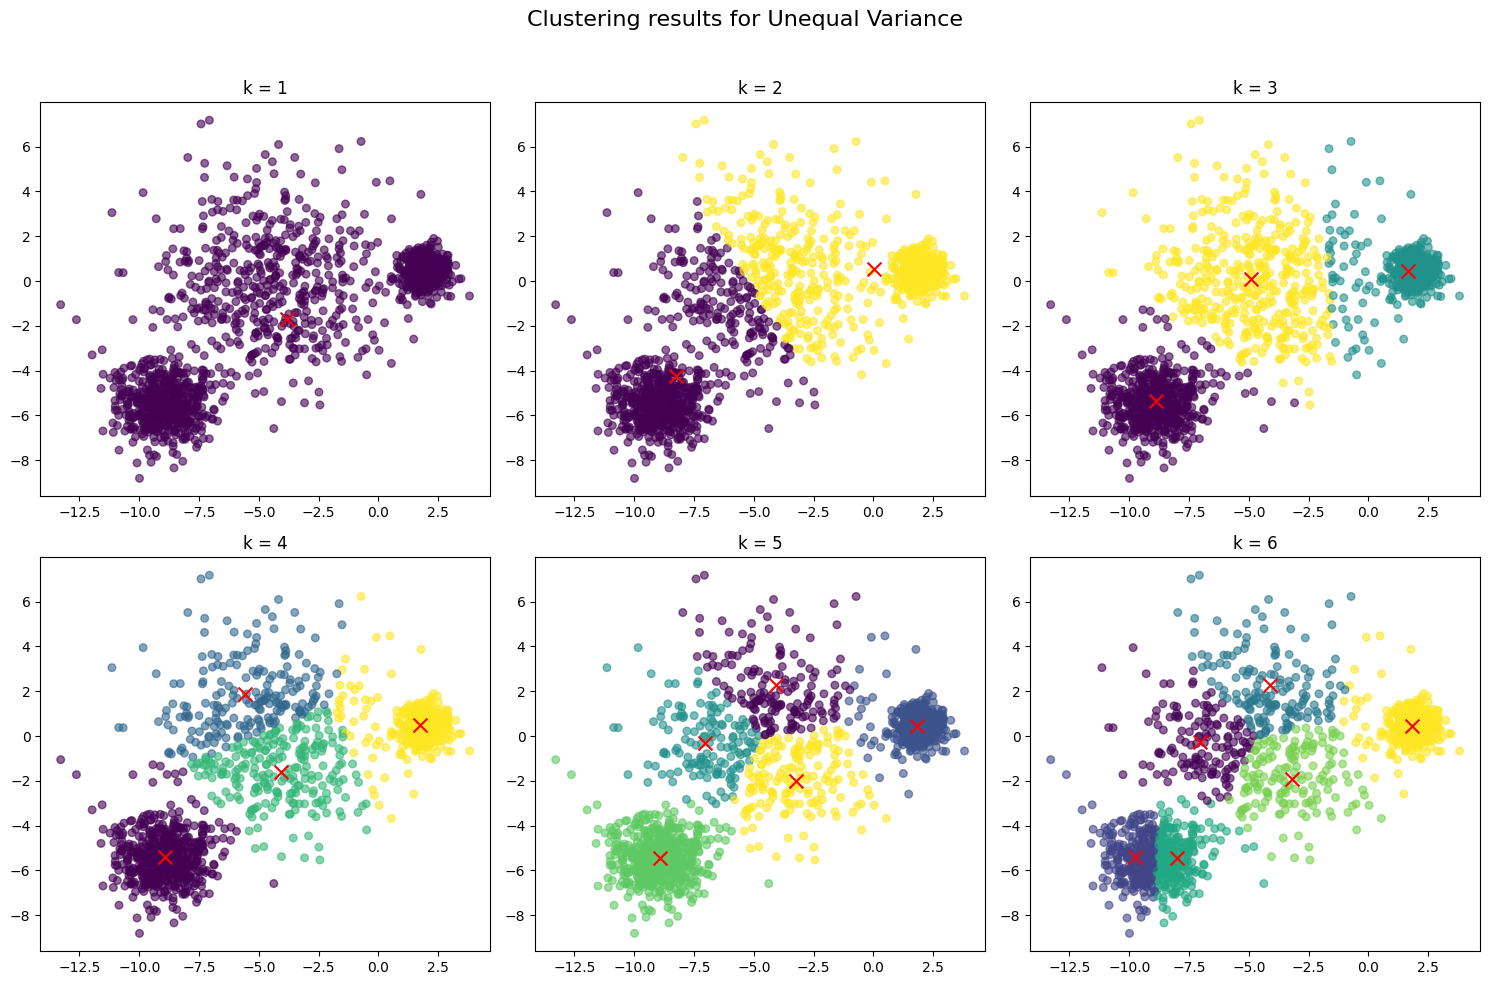

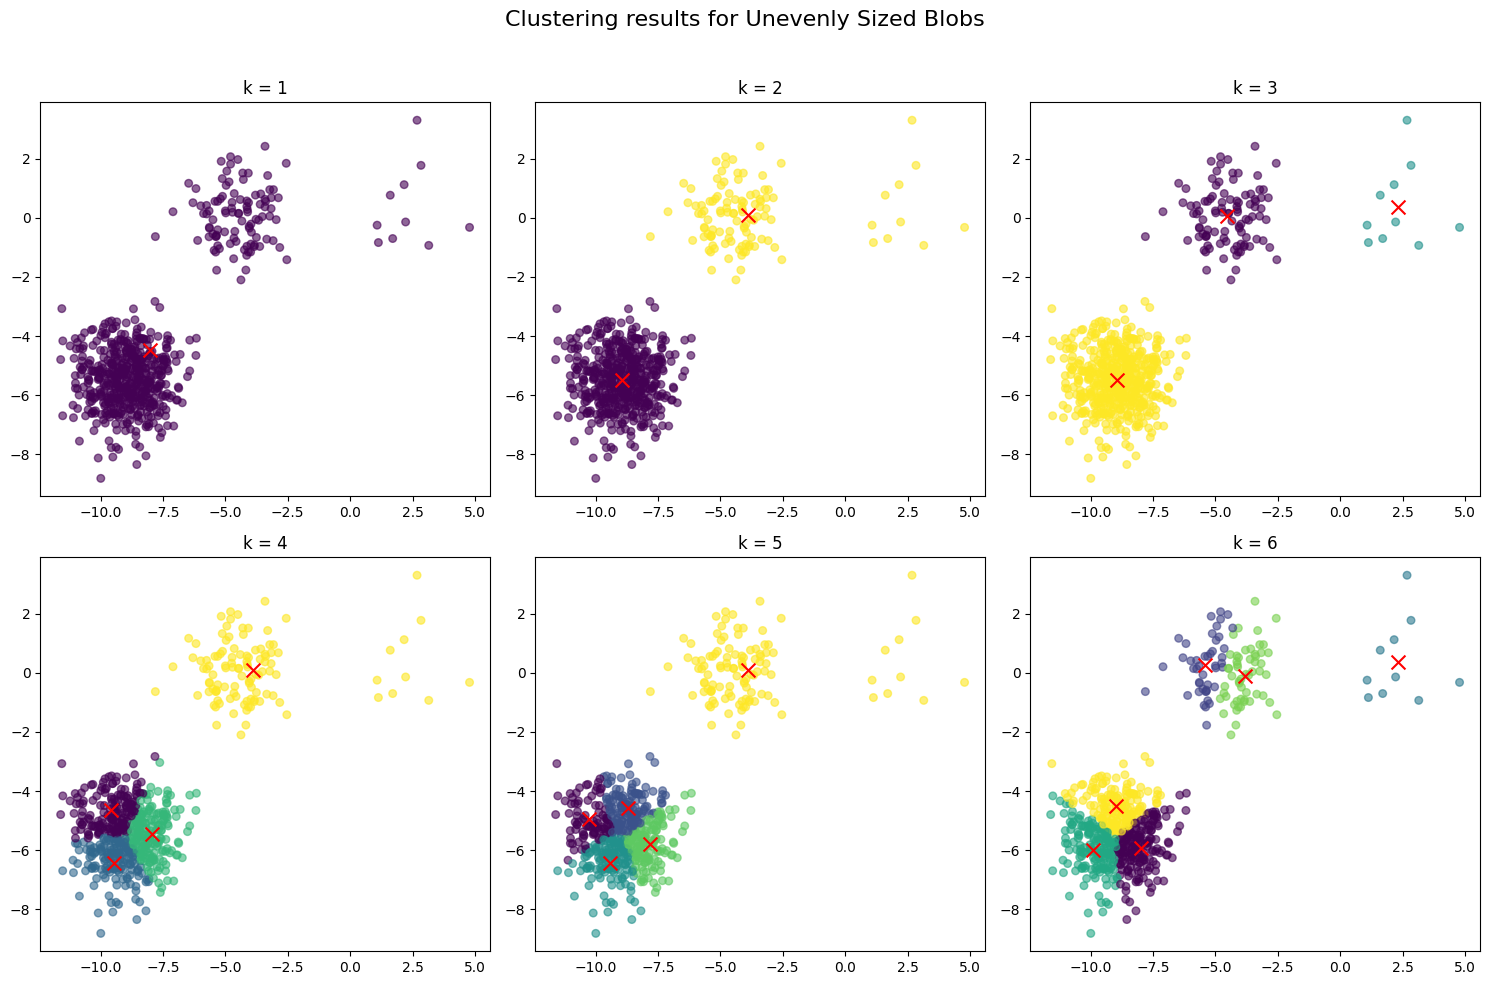

In [15]:
# classification results for different datasets and k values
k_values = [1, 2, 3, 4, 5, 6]
for dataset_name, X in datasets.items():
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f"Clustering results for {dataset_name}", fontsize=16)

    for idx, k in enumerate(k_values):
        labels, centers = lloyds_algorithm(X, k)
        
        ax = axes[idx // 3, idx % 3]
        ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30, alpha=0.6)
        ax.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=100)
        ax.set_title(f"k = {k}")
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

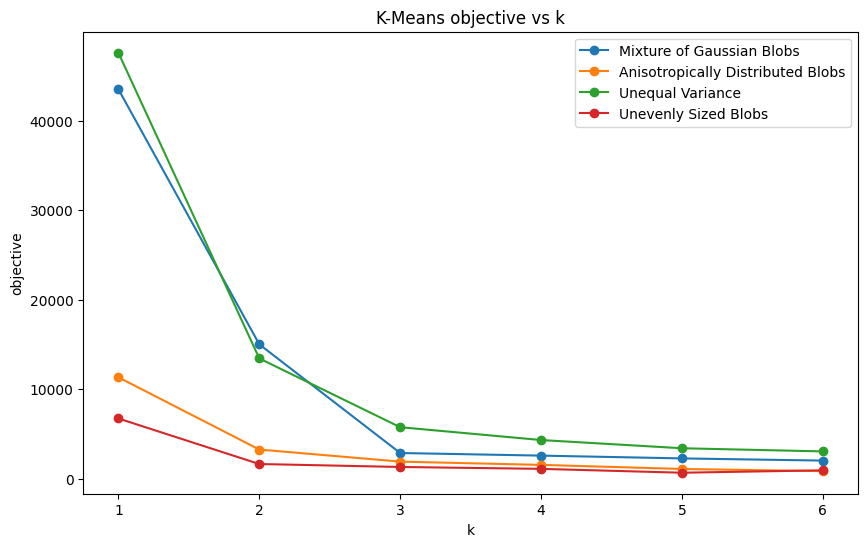

In [16]:
# objective plot
objective_values = {name: [] for name in datasets}

for dataset_name, X in datasets.items():
    for k in k_values:
        labels, centers = lloyds_algorithm(X, k)
        objective = sum(np.linalg.norm(X[i] - centers[labels[i]])**2 for i in range(len(X)))
        objective_values[dataset_name].append(objective)

plt.figure(figsize=(10, 6))
for dataset_name, objectives in objective_values.items():
    plt.plot(k_values, objectives, marker='o', label=dataset_name)

plt.xlabel("k")
plt.ylabel("objective")
plt.title("K-Means objective vs k")
plt.legend()
plt.show()

- Its hard for K-means to find the right clusters for non-gaussian  data.
- Choosing cluster number heuristic works on all datasets as 3 is breaking point of objective function for all datasets.


## Subtask 3: K-means++ initialization
(5 points)
Implement k-means++ for initializing the cluster centers as part of your implementation
of Lloyd’s algorithm.  
6  
□ Report the same plots as in the previous task. Are there any differences?  

In [17]:
def kmeans_pp_initialization(X, k):
    """Initializes cluster centers using k-means++."""
    n_samples, _ = X.shape
    # first center is chosen randomly
    centers = [X[np.random.randint(n_samples)]] 

    for _ in range(1, k):
        # compute distances to the nearest center for each point
        distances = np.array([min(np.linalg.norm(x - c)**2 for c in centers) for x in X])
        probabilities = distances / distances.sum()
        # choice with probability
        next_center = X[np.random.choice(n_samples, p=probabilities)]
        centers.append(next_center)

    return np.array(centers)

def lloyds_algorithm_kmeans_pp(X, k, max_iters=100, tol=1e-4):
    """Implements Lloyd's Algorithm with k-means++ initialization."""
    centers = kmeans_pp_initialization(X, k)

    for _ in range(max_iters):
         # assign points to the nearest cluster
        labels = np.argmin(np.linalg.norm(X[:, np.newaxis] - centers, axis=2), axis=1)
        
        new_centers = np.array([X[labels == i].mean(axis=0) if len(X[labels == i]) > 0 
                                else X[np.random.randint(len(X))] for i in range(k)])
        
        # check for convergence
        if np.linalg.norm(new_centers - centers) < tol:
            break
        centers = new_centers

    return labels, centers

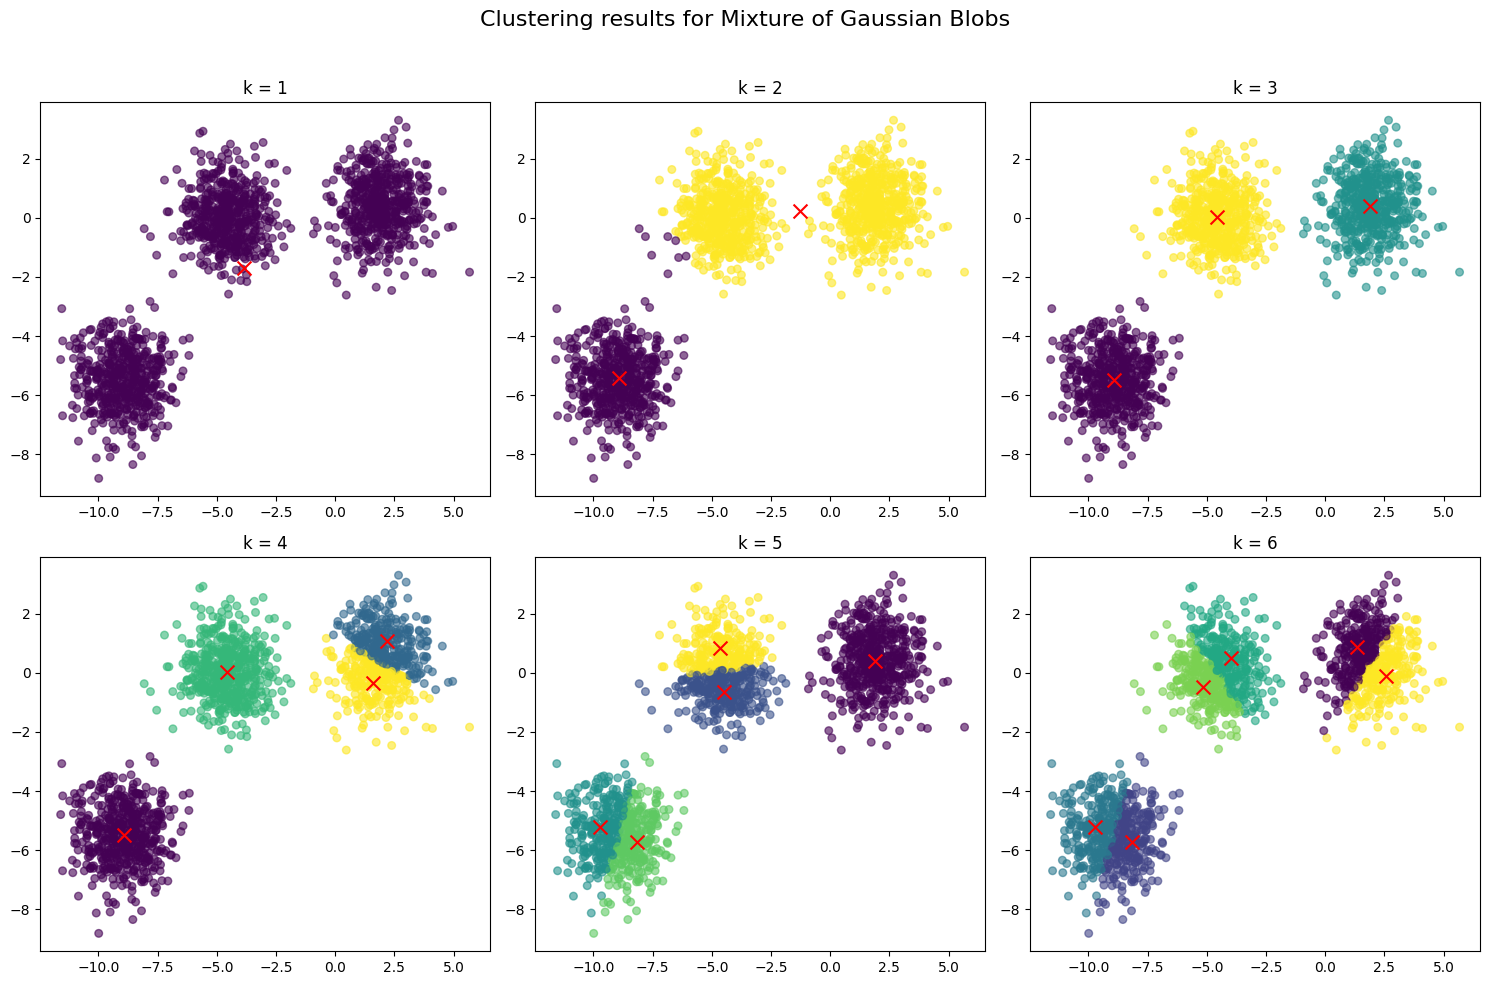

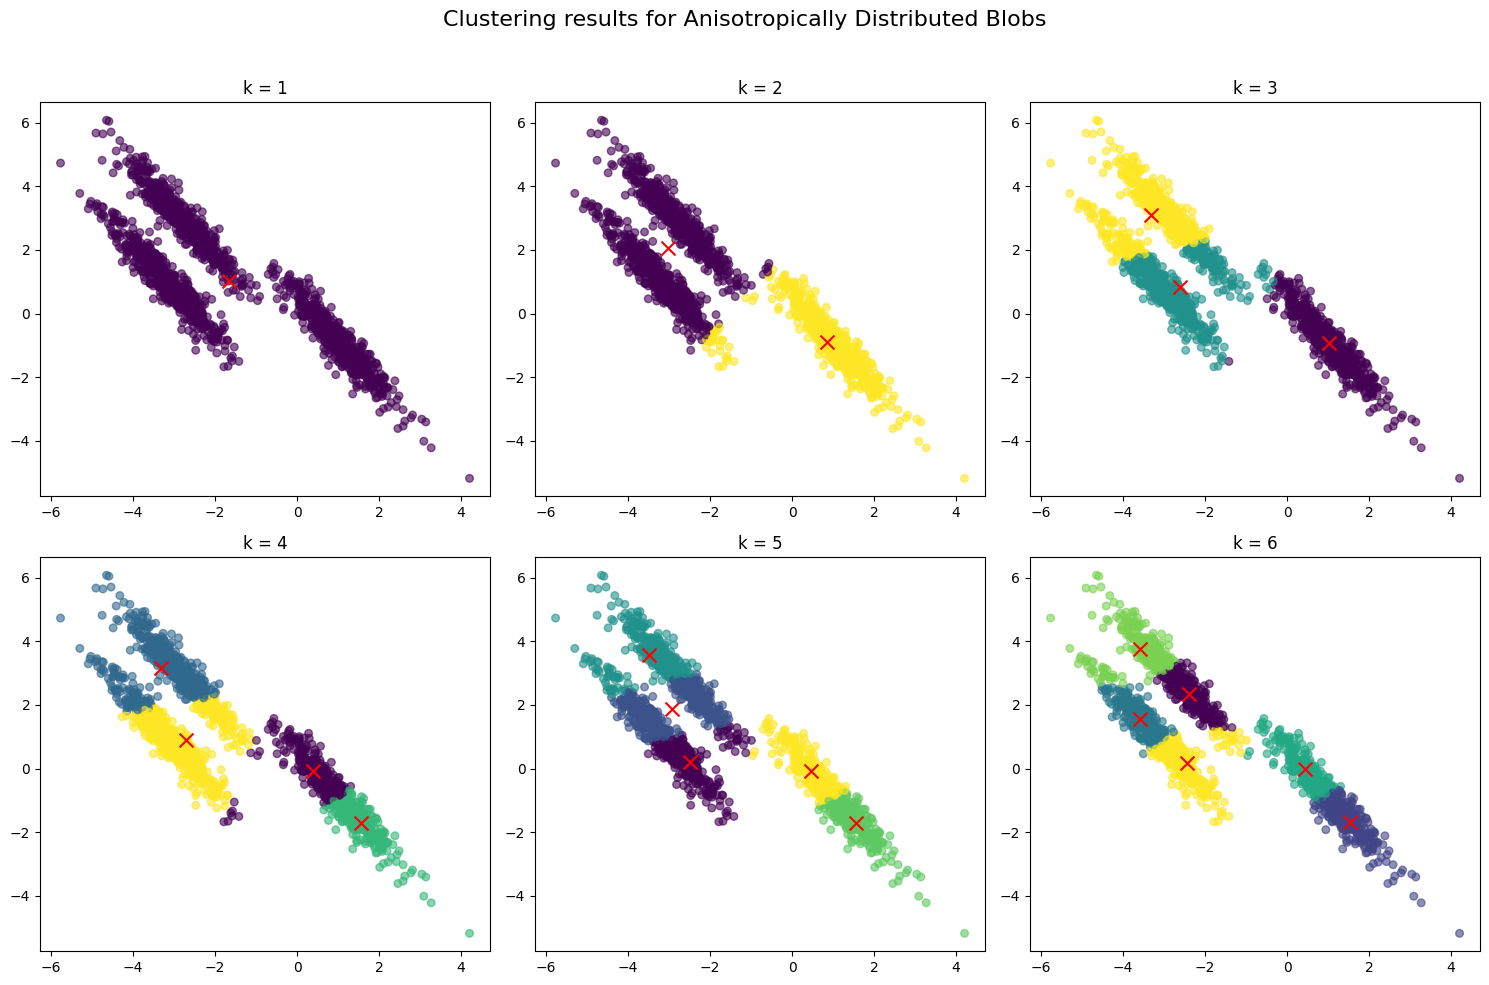

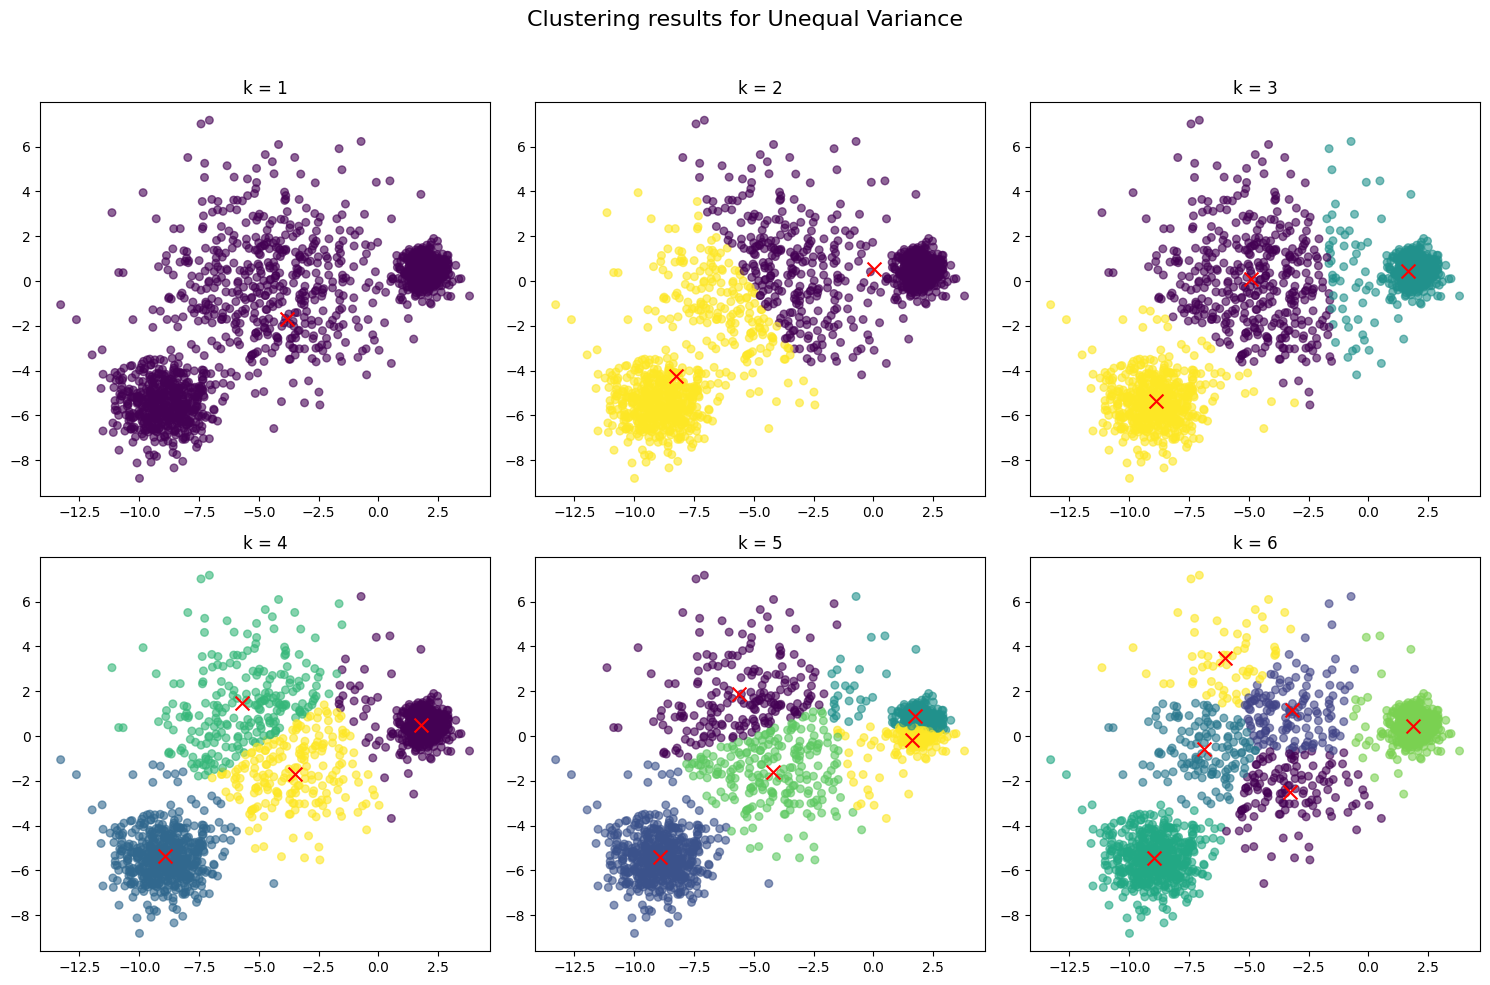

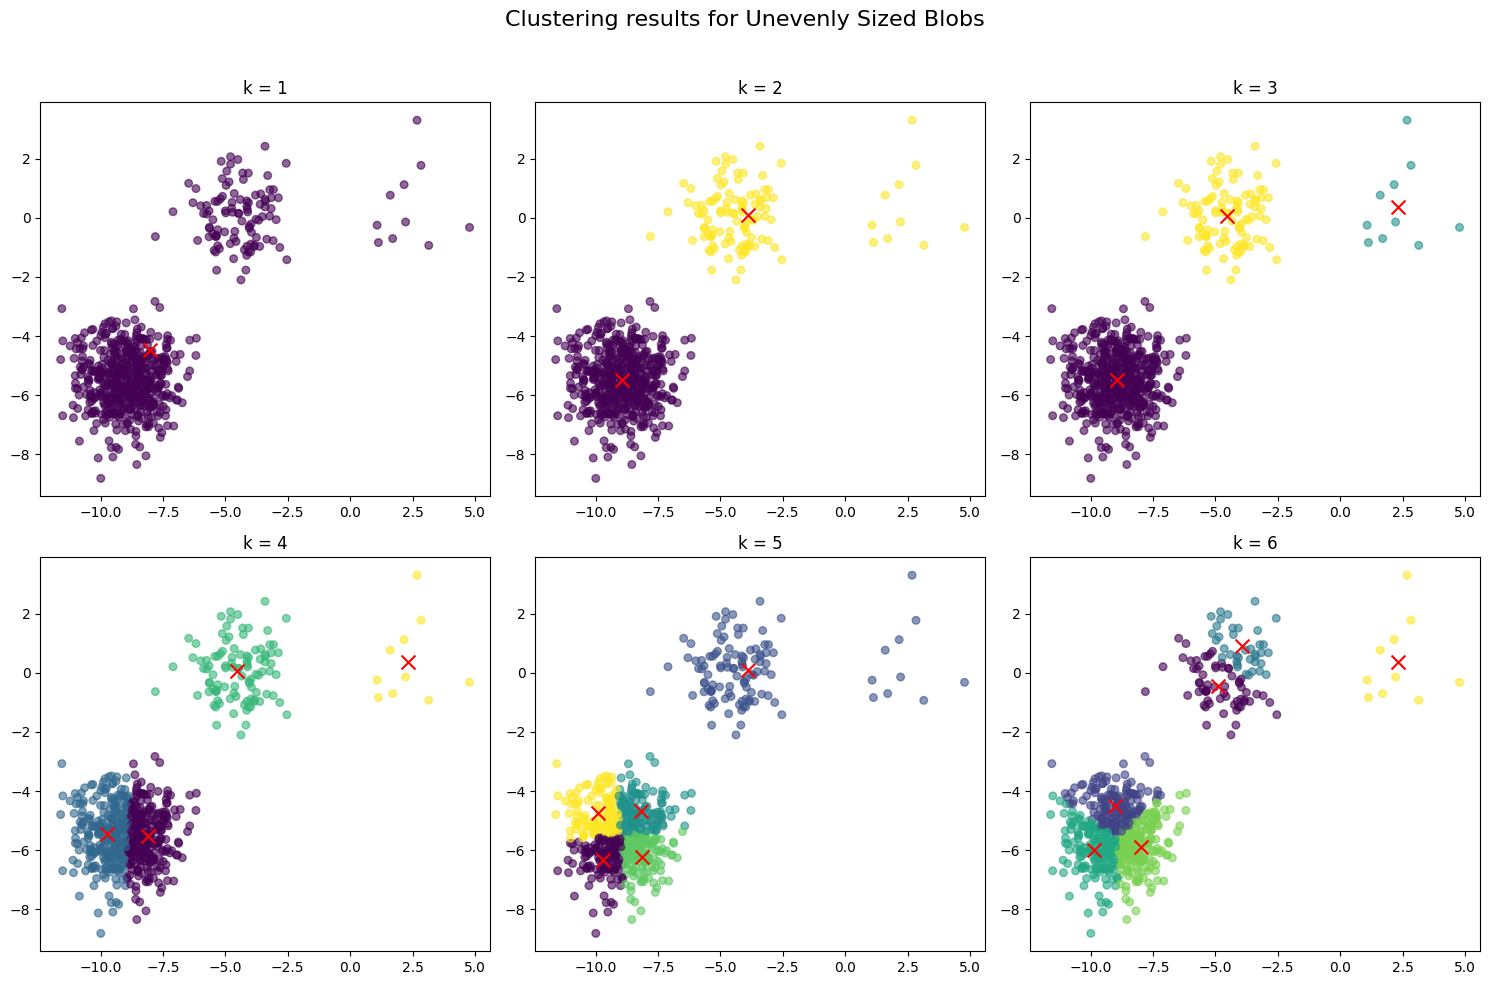

In [18]:
# classification results for different datasets and k values
k_values = [1, 2, 3, 4, 5, 6]
for dataset_name, X in datasets.items():
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f"Clustering results for {dataset_name}", fontsize=16)

    for idx, k in enumerate(k_values):
        labels, centers = lloyds_algorithm_kmeans_pp(X, k)
        
        ax = axes[idx // 3, idx % 3]
        ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30, alpha=0.6)
        ax.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=100)
        ax.set_title(f"k = {k}")
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

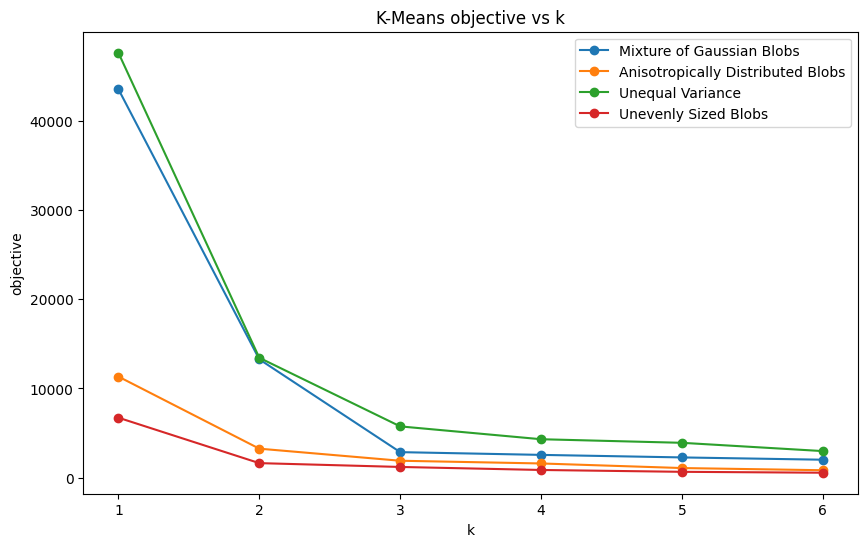

In [19]:
# objective plot
objective_values = {name: [] for name in datasets}

for dataset_name, X in datasets.items():
    for k in k_values:
        labels, centers = lloyds_algorithm_kmeans_pp(X, k)
        objective = sum(np.linalg.norm(X[i] - centers[labels[i]])**2 for i in range(len(X)))
        objective_values[dataset_name].append(objective)

plt.figure(figsize=(10, 6))
for dataset_name, objectives in objective_values.items():
    plt.plot(k_values, objectives, marker='o', label=dataset_name)

plt.xlabel("k")
plt.ylabel("objective")
plt.title("K-Means objective vs k")
plt.legend()
plt.show()

- Although kmeas++ generally suppose to work better, this it has almost the same results as kmeans.